##### Task 5: Strategy Backtesting

Simulate the performance of the optimized portfolio against a simple benchmark (60% SPY / 40% BND) over the last year of data.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys 
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data_manager import DataManager
from src.task5_backtest import BacktestOrchestrator

plt.style.use('seaborn-v0_8')
%matplotlib inline


### 1) Data and Backtest Window

Use last year as backtest window (Aug 1, 2024 — Jul 31, 2025).


In [5]:
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'
BACKTEST_START = '2024-08-01'
BACKTEST_END = '2025-07-31'

TICKERS = ['TSLA', 'BND', 'SPY']

dm = DataManager(data_source='yfinance')
raw = dm.fetch_data(TICKERS, start_date=START_DATE, end_date=END_DATE, frequency='1d')

# Robustly extract Adjusted Close regardless of MultiIndex orientation
def get_adj_close(raw_df: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:
    if isinstance(raw_df.columns, pd.MultiIndex):
        level0 = set(raw_df.columns.get_level_values(0))
        level1 = set(raw_df.columns.get_level_values(1))
        if set(tickers).issubset(level0):
            # Columns like ('TSLA', 'Adj Close')
            adj = raw_df.xs('Close', axis=1, level=1)
            return adj.loc[:, tickers].dropna()
        elif 'Close' in level0:
            # Columns like ('Adj Close', 'TSLA')
            adj = raw_df.xs('Close', axis=1, level=0)
            return adj.loc[:, tickers].dropna()
        else:
            raise KeyError("'Close' not found in MultiIndex columns")
    else:
        # Single ticker fallback
        if 'Close' in raw_df.columns and len(tickers) == 1:
            return raw_df[['Close']].rename(columns={'Close': tickers[0]}).dropna()
        raise KeyError('Unexpected columns format for downloaded data')

prices = get_adj_close(raw, TICKERS)

orch = BacktestOrchestrator(initial_capital=100000, transaction_costs=0.001)
windowed_returns = orch.prepare_returns(prices, BACKTEST_START, BACKTEST_END)
prices.tail(), windowed_returns.head()

[*********************100%***********************]  3 of 3 completed


(Ticker            TSLA        BND         SPY
 Date                                         
 2025-07-24  305.299988  72.698860  634.419983
 2025-07-25  316.059998  72.878265  637.099976
 2025-07-28  325.589996  72.758659  636.940002
 2025-07-29  321.200012  73.137398  635.260010
 2025-07-30  319.040009  72.948036  634.460022,
 Ticker          TSLA       BND       SPY
 Date                                    
 2024-08-01 -0.065541  0.003738 -0.014161
 2024-08-02 -0.042378  0.011418 -0.018618
 2024-08-05 -0.042327 -0.000941 -0.029124
 2024-08-06  0.008850 -0.006188  0.009220
 2024-08-07 -0.044258 -0.002436 -0.006684)

### 2) Strategy and Benchmark Weights

- Strategy: Use initial optimal weights from Task 4 (enter them or load from saved output). For this template, set a reasonable example.
- Benchmark: 60% SPY / 40% BND (TSLA weight = 0).


In [6]:
# Example strategy weights (replace with Task 4 optimal weights)
strategy_weights_map = {'TSLA': 0.3, 'BND': 0.3, 'SPY': 0.4}

benchmark_weights_map = {'TSLA': 0.0, 'BND': 0.4, 'SPY': 0.6}

strategy_weights_df = orch.make_constant_weights(windowed_returns.index, strategy_weights_map)
benchmark_weights_df = orch.make_constant_weights(windowed_returns.index, benchmark_weights_map)

strategy_weights_df.head(), benchmark_weights_df.head()


(            TSLA  BND  SPY
 Date                      
 2024-08-01   0.3  0.3  0.4
 2024-08-02   0.3  0.3  0.4
 2024-08-05   0.3  0.3  0.4
 2024-08-06   0.3  0.3  0.4
 2024-08-07   0.3  0.3  0.4,
             TSLA  BND  SPY
 Date                      
 2024-08-01   0.0  0.4  0.6
 2024-08-02   0.0  0.4  0.6
 2024-08-05   0.0  0.4  0.6
 2024-08-06   0.0  0.4  0.6
 2024-08-07   0.0  0.4  0.6)

### 3) Run Backtests (Monthly Rebalance)


In [7]:
res_strategy = orch.run(windowed_returns, strategy_weights_df, rebalance_frequency='monthly')
res_benchmark = orch.run(windowed_returns, benchmark_weights_df, rebalance_frequency='monthly')

res_strategy.performance_metrics, res_benchmark.performance_metrics


({'total_return': np.float64(0.23712576224661253),
  'annualized_return': np.float64(0.2403015052037536),
  'annualized_volatility': np.float64(0.2778521026240327),
  'sharpe_ratio': np.float64(0.7928732700714812),
  'max_drawdown': np.float64(-0.2512178073000322),
  'var_95': np.float64(-0.02407854299328993),
  'cvar_95': np.float64(-0.03492624695075566),
  'calmar_ratio': np.float64(0.9565464637495179)},
 {'total_return': np.float64(0.09547040806944573),
  'annualized_return': np.float64(0.09667455406648151),
  'annualized_volatility': np.float64(0.12447746576422213),
  'sharpe_ratio': np.float64(0.6159713615291135),
  'max_drawdown': np.float64(-0.11288783687423642),
  'var_95': np.float64(-0.010861014029277182),
  'cvar_95': np.float64(-0.017831360843199275),
  'calmar_ratio': np.float64(0.8563770618989055)})

### 4) Plot Cumulative Returns vs Benchmark


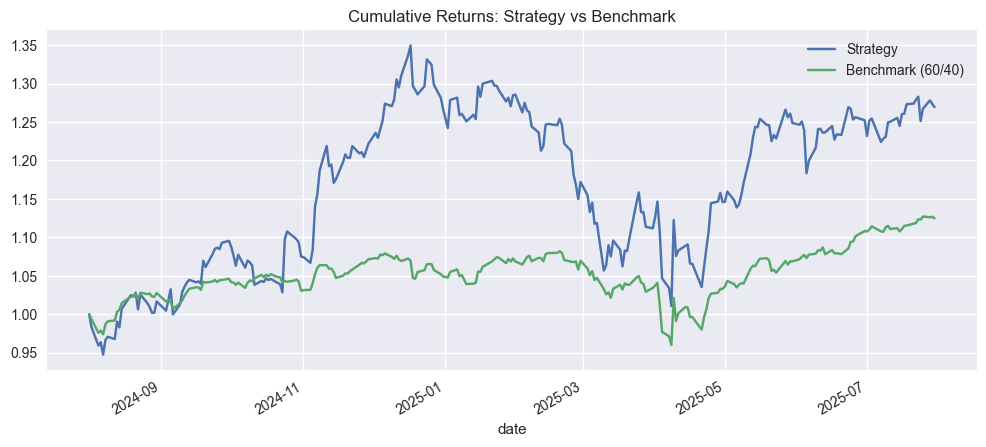

In [8]:
fig, ax = plt.subplots(figsize=(12,5))

# Compute cumulative curves
def cumcurve(portfolio_values: pd.DataFrame) -> pd.Series:
    return portfolio_values['portfolio_value'] / portfolio_values['portfolio_value'].iloc[0]

cum_strategy = cumcurve(res_strategy.portfolio_values)
cum_benchmark = cumcurve(res_benchmark.portfolio_values)

cum_strategy.plot(ax=ax, label='Strategy')
cum_benchmark.plot(ax=ax, label='Benchmark (60/40)')

ax.set_title('Cumulative Returns: Strategy vs Benchmark')
ax.legend();


### 5) Summary and Conclusion

- Show total return and Sharpe for both, and provide a brief interpretation.


In [9]:
summary = pd.DataFrame([
    {
        'Name': 'Strategy',
        'TotalReturn': res_strategy.performance_metrics['total_return'],
        'Sharpe': res_strategy.performance_metrics['sharpe_ratio'],
        'AnnReturn': res_strategy.performance_metrics['annualized_return'],
        'AnnVol': res_strategy.performance_metrics['annualized_volatility'],
    },
    {
        'Name': 'Benchmark',
        'TotalReturn': res_benchmark.performance_metrics['total_return'],
        'Sharpe': res_benchmark.performance_metrics['sharpe_ratio'],
        'AnnReturn': res_benchmark.performance_metrics['annualized_return'],
        'AnnVol': res_benchmark.performance_metrics['annualized_volatility'],
    },
])
summary.set_index('Name')


,TotalReturn,Sharpe,AnnReturn,AnnVol
Name,,,,
Strategy,0.237126,0.792873,0.240302,0.277852
Benchmark,0.095470,0.615971,0.096675,0.124477
